In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../") # go to parent directory
import numpy as np 
import matplotlib.pyplot as plt
from pypde import *
from pypde.solver.utils import eigdecomp

N,M = 20,20
shape = (N,M)

def _f(xx,yy,arg=np.pi/2):
    return np.cos(arg*xx)*np.cos(arg*yy)

def _fsol(xx,yy,arg=np.pi/2):
        return np.cos(arg*xx)*np.cos(arg*yy)*-1/arg**2/2


## Setup Field

In [2]:
u = Field(shape,("CD","CD"))
x,y = u.x, u.y
xx,yy = np.meshgrid(x,y,indexing="ij")

f = Field(shape,("CH","CH"))
f.v = _f(xx,yy)
f.forward()
fhat = f.vhat

sol = _fsol(xx,yy)

## Matrices

In [3]:
# --- Matrices ----
Sx = u.xs[0].S
Bx = u.xs[0].family.B(2,2)
Ix = u.xs[0].family.I(2)
Ax = Ix@Sx
Cx = Bx@Sx

Sy = u.xs[1].S
By = u.xs[1].family.B(2,2)
Iy = u.xs[1].family.I(2)
Ay = Iy@Sy
Cy = By@Sy

# -- Eigendecomposition ---
CyI = np.linalg.inv(Cy)
wy,Qy,QyI = eigdecomp( CyI@Ay )

Hy = QyI@CyI@By

## SolverPlan

In [4]:
# --- Solver Plans ---
solver = SolverPlan()
solver.add_rhs(PlanRHS(Bx,ndim=2,axis=0))      # rhs
solver.add_rhs(PlanRHS(Hy,ndim=2,axis=1))    # rhs

plan_poisson = PlanLHS(Ax,alpha=wy,C=Cx,ndim=2,axis=0,method="poisson")
solver.add_lhs( plan_poisson ) #lhs
solver.add_lhs( PlanLHS(Qy,ndim=2,axis=1,method="multiply") ) #lhs

solver.show_plan()

Plans RHS:
1 ) Apply method 'multiply' along axis 0 
2 ) Apply method 'multiply' along axis 1 

Plans LHS:
1 ) Apply method 'poisson' along axis 0 
2 ) Apply method 'multiply' along axis 1 



In [5]:
rhs = solver.solve_rhs(fhat)
vhat = solver.solve_lhs(rhs)
vhat = vhat#@Qy.T

In [6]:
u.vhat = vhat
u.backward()

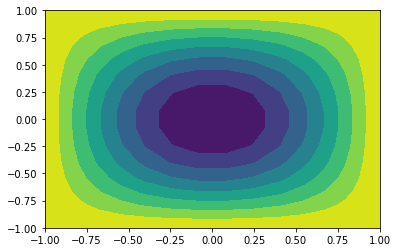

-0.1992517740855377


In [7]:
plt.contourf(xx,yy,u.v)
plt.show()
print(u.v.min())

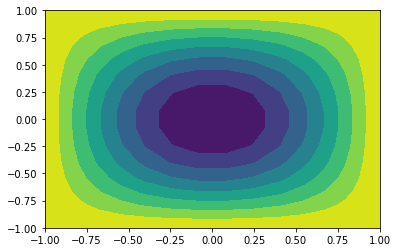

-0.19925177408555428


In [8]:
plt.contourf(xx,yy,sol)
plt.show()
print(sol.min())